<a href="https://colab.research.google.com/github/antonsysoev/Ass/blob/main/Ramp_Met_RSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Пакет gridExtra не установлен. Графики будут отображены последовательно.


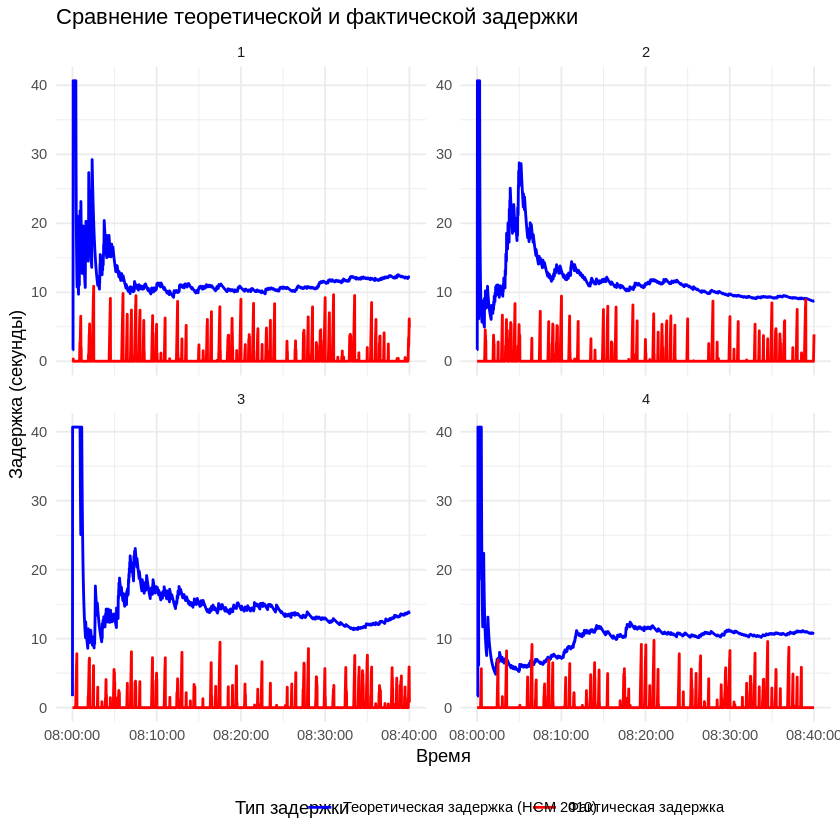

Статистика по перекресткам:
# A tibble: 4 × 8
  intersection total_vehicles passed pass_rate avg_hcm_delay avg_actual_delay
         <int>          <int>  <int>     <dbl>         <dbl>            <dbl>
1            1            304    303     0.997          12.3             2.13
2            2            266    265     0.996          12.6             1.89
3            3            317    316     0.997          15.3             1.79
4            4            290    289     0.997          10.6             1.71
# ℹ 2 more variables: max_actual_delay <dbl>, avg_queue <dbl>

Все фактические задержки неотрицательные.


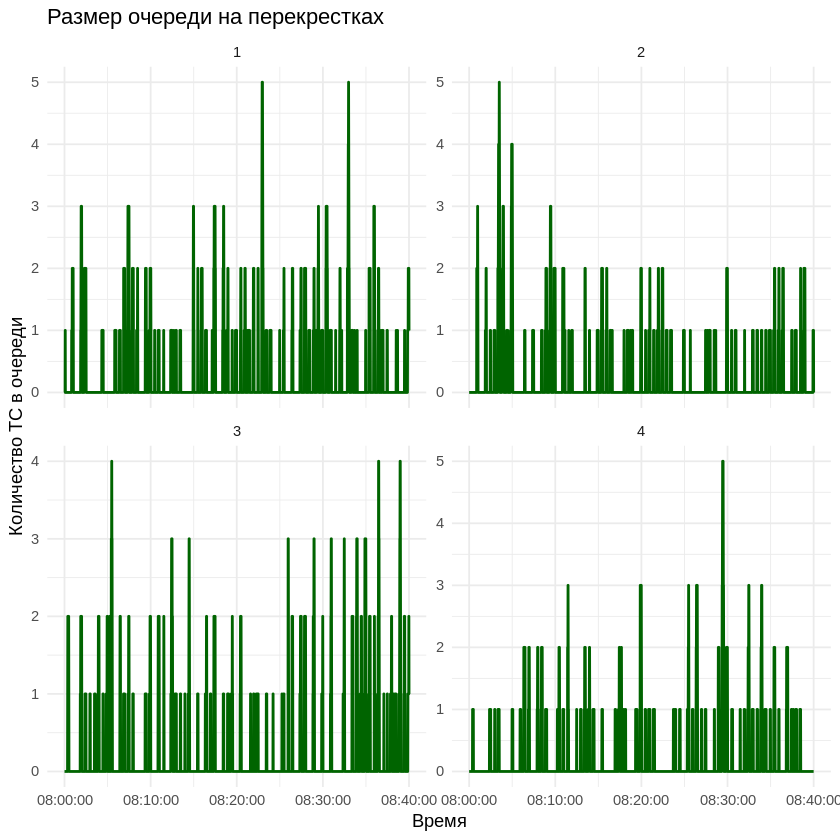

In [ ]:
library(dplyr)
library(tidyr)
library(lubridate)
library(ggplot2)

# Проверка и загрузка gridExtra
if (!requireNamespace("gridExtra", quietly = TRUE)) {
  cat("Пакет gridExtra не установлен. Графики будут отображены последовательно.\n")
  has_gridExtra <- FALSE
} else {
  library(gridExtra)
  has_gridExtra <- TRUE
}

# Функция расчета задержки по модели HCM 2010
hcm_delay <- function(cycle_length, green_time, saturation_flow, arrival_rate) {
  # Защита от некорректных входных данных
  if (any(c(cycle_length, green_time, saturation_flow) <= 0) || is.na(arrival_rate)) {
    return(0)
  }

  # Расчет пропускной способности
  capacity <- (green_time / cycle_length) * saturation_flow
  if (capacity <= 0) return(0)

  # Степень насыщения (X)
  X <- arrival_rate / capacity
  X <- ifelse(X >= 1, 0.999, ifelse(X < 0, 0, X))  # Ограничение 0 ≤ X < 1

  # 1. Uniform Delay (d1)
  d1 <- 0.5 * cycle_length * (1 - green_time/cycle_length)^2 /
    (1 - min(X, 0.9) * green_time/cycle_length)

  # 2. Incremental Delay (d2)
  T <- 0.25   # Период анализа (часы) - 15 минут
  k <- 0.5    # Коэффициент типа управления
  I <- 1.0    # Коэффициент фильтрации
  d2 <- 900 * T * ((X - 1) + sqrt((X - 1)^2 + (8 * k * I * X)/(capacity * T)))
  d2 <- max(0, d2, na.rm = TRUE)  # Гарантируем неотрицательность

  # Итоговая задержка (сек/транспортное средство)
  total_delay <- d1 + d2
  return(max(0, total_delay, na.rm = TRUE))
}

# Функция генерации данных о трафике
generate_traffic_dataset <- function(start_time, total_duration, lambda, n_intersections = 4) {
  start_time <- as.POSIXct(start_time)

  arrival_times <- c(0)
  while (tail(arrival_times, 1) < total_duration) {
    next_arrival <- tail(arrival_times, 1) + rexp(1, rate = lambda)
    if (next_arrival <= total_duration) {
      arrival_times <- c(arrival_times, next_arrival)
    } else {
      break
    }
  }

  if (length(arrival_times) > 1) {
    arrival_times <- arrival_times[-1]
  } else {
    arrival_times <- numeric(0)
  }

  if (length(arrival_times) > 0) {
    df <- data.frame(
      vehicle_id = 1:length(arrival_times),
      arrival_timestamp = start_time + arrival_times,
      arrival_seconds = arrival_times,
      intersection = sample(1:n_intersections, length(arrival_times), replace = TRUE),
      processing_time = pmax(1, rnorm(length(arrival_times), mean = 5, sd = 1)),
      hcm_delay = 0,
      actual_delay = 0,  # Инициализация фактической задержки
      exit_time = NA,
      stringsAsFactors = FALSE
    )
  } else {
    df <- data.frame(
      vehicle_id = integer(),
      arrival_timestamp = as.POSIXct(character()),
      arrival_seconds = numeric(),
      intersection = integer(),
      processing_time = numeric(),
      hcm_delay = numeric(),
      actual_delay = numeric(),
      exit_time = numeric(),
      stringsAsFactors = FALSE
    )
  }

  return(df)
}

# Основная функция моделирования с защитой от отрицательных задержек
simulate_traffic <- function(traffic_data, start_time, total_duration,
                            green_durations, red_durations, capacity = 1100) {
  start_time <- as.POSIXct(start_time)
  n_intersections <- length(green_durations)

  # Инициализация очередей (храним индексы транспортных средств)
  queues <- lapply(1:n_intersections, function(x) integer())
  arrival_counts <- rep(0, n_intersections)

  # Создаем dataframe для хранения результатов по секундам
  time_stats <- data.frame(
    timestamp = rep(start_time + 0:total_duration, each = n_intersections),
    intersection = rep(1:n_intersections, total_duration + 1),
    time_seconds = rep(0:total_duration, each = n_intersections),
    queue_size = 0,
    hcm_delay = 0,
    actual_delay = 0,
    arrival_rate = 0,
    stringsAsFactors = FALSE
  )

  # Основной цикл моделирования
  for (t in 0:total_duration) {
    current_time <- start_time + t

    # Добавление прибывающих машин в очереди
    arrivals <- which(floor(traffic_data$arrival_seconds) == t)

    if (length(arrivals) > 0) {
      for (i in arrivals) {
        int <- traffic_data$intersection[i]
        queues[[int]] <- c(queues[[int]], i)
        arrival_counts[int] <- arrival_counts[int] + 1
      }
    }

    # Обработка каждого перекрестка
    for (int in 1:n_intersections) {
      idx <- which(time_stats$time_seconds == t & time_stats$intersection == int)
      cycle_length <- green_durations[int] + red_durations[int]
      cycle_pos <- t %% cycle_length
      is_green <- cycle_pos < green_durations[int]

      # Расчет интенсивности прибытия (машин/час)
      arrival_rate <- ifelse(t > 0, arrival_counts[int] / t * 3600, 0)

      # Расчет теоретической задержки по HCM 2010
      hcm_delay_val <- ifelse(is.finite(arrival_rate),
                             hcm_delay(cycle_length, green_durations[int], capacity, arrival_rate),
                             0)

      # Обработка очереди при зеленом свете
      current_actual_delay <- 0
      if (is_green && length(queues[[int]]) > 0) {
        # Берем первую машину в очереди
        vehicle_idx <- queues[[int]][1]

        # Если машина еще не обрабатывается
        if (is.na(traffic_data$exit_time[vehicle_idx])) {
          # Время обработки = время проезда перекрестка
          exit_time <- t + traffic_data$processing_time[vehicle_idx]

          # Расчет фактической задержки с защитой от отрицательных значений
          actual_delay <- max(0, t - traffic_data$arrival_seconds[vehicle_idx], na.rm = TRUE)

          # Обновляем данные по машине
          traffic_data$hcm_delay[vehicle_idx] <- hcm_delay_val
          traffic_data$actual_delay[vehicle_idx] <- actual_delay
          traffic_data$exit_time[vehicle_idx] <- exit_time

          # Удаляем машину из очереди
          queues[[int]] <- queues[[int]][-1]

          current_actual_delay <- actual_delay
        }
      }

      # Расчет средней фактической задержки в текущий момент (с защитой от отрицательных значений)
      if (length(queues[[int]]) > 0) {
        current_delays <- pmax(0, t - traffic_data$arrival_seconds[queues[[int]]], na.rm = TRUE)
        current_actual_delay <- mean(current_delays)
      }

      # Сохраняем данные для текущей секунды
      time_stats$queue_size[idx] <- length(queues[[int]])
      time_stats$hcm_delay[idx] <- hcm_delay_val
      time_stats$actual_delay[idx] <- current_actual_delay
      time_stats$arrival_rate[idx] <- arrival_rate
    }
  }

  # Для машин, которые не проехали, устанавливаем задержку (с защитой от отрицательных значений)
  not_passed <- is.na(traffic_data$exit_time)
  traffic_data$actual_delay[not_passed] <- pmax(0, total_duration - traffic_data$arrival_seconds[not_passed], na.rm = TRUE)
  traffic_data$exit_time[not_passed] <- total_duration

  return(list(time_stats = time_stats,
             vehicle_stats = traffic_data,
             queues = queues))
}

# Параметры светофоров
green_durations <- c(20, 20, 20, 20)
red_durations <- c(10, 10, 10, 10)
capacity <- 900  # машин/час

# Генерация данных
set.seed(123)
start_time <- "2023-11-15 08:00:00"
traffic_data <- generate_traffic_dataset(
  start_time = start_time,
  total_duration = 2400,  # 10 минут
  lambda = 0.5           # Интенсивность прибытия
)

# Моделирование
result <- simulate_traffic(
  traffic_data,
  start_time = start_time,
  total_duration = 2400,
  green_durations = green_durations,
  red_durations = red_durations,
  capacity = capacity
)

# Визуализация результатов
plot_comparison <- ggplot(result$time_stats, aes(x = timestamp)) +
  geom_line(aes(y = hcm_delay, color = "Теоретическая задержка (HCM 2010)"), linewidth = 0.8) +
  geom_line(aes(y = actual_delay, color = "Фактическая задержка"), linewidth = 0.8) +
  facet_wrap(~intersection, scales = "free_y", ncol = 2) +
  scale_x_datetime(date_labels = "%H:%M:%S") +
  labs(title = "Сравнение теоретической и фактической задержки",
       x = "Время",
       y = "Задержка (секунды)",
       color = "Тип задержки") +
  theme_minimal() +
  scale_color_manual(values = c("Теоретическая задержка (HCM 2010)" = "blue",
                               "Фактическая задержка" = "red")) +
  theme(legend.position = "bottom")

plot_queues <- ggplot(result$time_stats, aes(x = timestamp, y = queue_size)) +
  geom_line(color = "darkgreen", linewidth = 0.8) +
  facet_wrap(~intersection, scales = "free_y", ncol = 2) +
  scale_x_datetime(date_labels = "%H:%M:%S") +
  labs(title = "Размер очереди на перекрестках",
       x = "Время",
       y = "Количество ТС в очереди") +
  theme_minimal()

# Вывод графиков
if (has_gridExtra) {
  grid.arrange(plot_comparison, plot_queues, ncol = 1, heights = c(2, 1))
} else {
  print(plot_comparison)
  print(plot_queues)
}

# Статистика по перекресткам (с проверкой на NA)
stats <- result$vehicle_stats %>%
  group_by(intersection) %>%
  summarise(
    total_vehicles = n(),
    passed = sum(!is.na(exit_time) & exit_time < max(exit_time, na.rm = TRUE)),
    pass_rate = passed / total_vehicles,
    avg_hcm_delay = mean(hcm_delay[is.finite(hcm_delay)]),
    avg_actual_delay = mean(actual_delay[is.finite(actual_delay)]),
    max_actual_delay = max(actual_delay[is.finite(actual_delay)]),
    avg_queue = mean(result$time_stats$queue_size[result$time_stats$intersection == first(intersection)])
  )

cat("Статистика по перекресткам:\n")
print(stats)

# Проверка на отрицательные задержки
if (any(result$vehicle_stats$actual_delay < 0, na.rm = TRUE)) {
  cat("\nВНИМАНИЕ: Обнаружены отрицательные фактические задержки!\n")
} else {
  cat("\nВсе фактические задержки неотрицательные.\n")
}

Пакет gridExtra не установлен. Графики будут отображены последовательно.


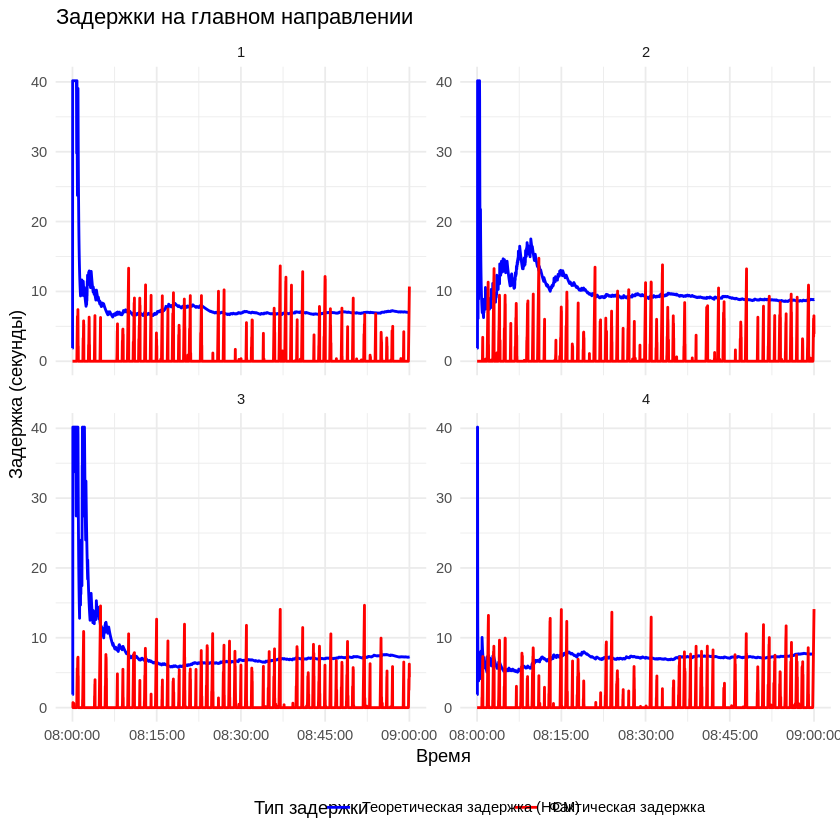

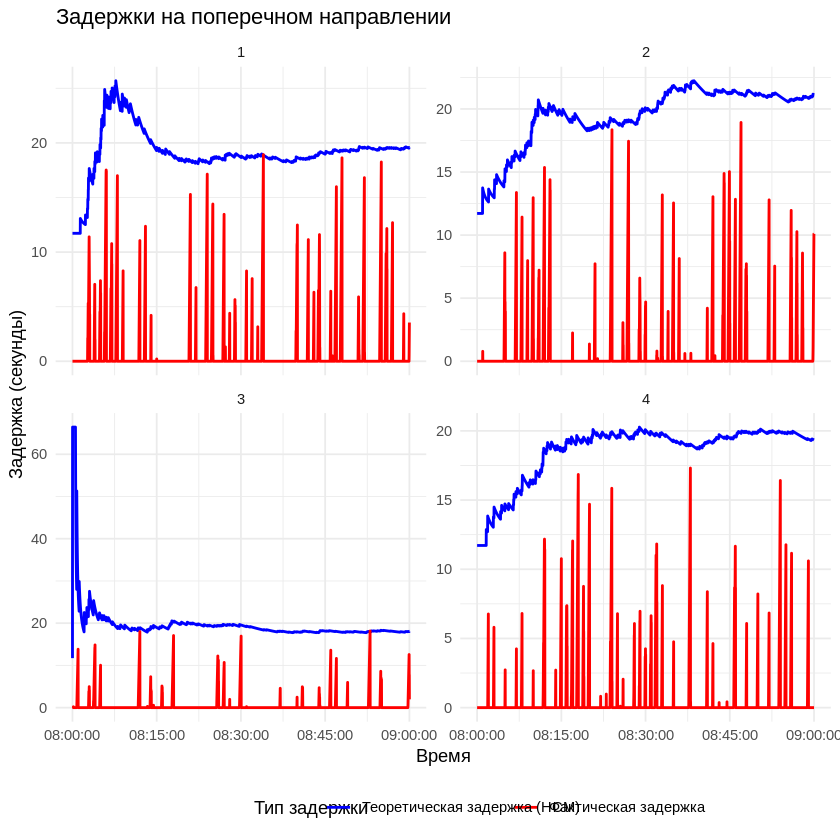

Статистика по перекресткам и направлениям:
# A tibble: 8 × 9
  intersection direction total_vehicles passed pass_rate avg_hcm_delay
         <int> <chr>              <int>  <int>     <dbl>         <dbl>
1            1 main                 393    392     0.997          8.20
2            2 main                 448    447     0.998         10.5 
3            3 main                 402    401     0.998          9.01
4            4 main                 415    414     0.998          7.20
5            1 cross                168    167     0.994         19.6 
6            2 cross                186    185     0.995         19.8 
7            3 cross                147    146     0.993         20.2 
8            4 cross                165    164     0.994         18.9 
# ℹ 3 more variables: avg_actual_delay <dbl>, max_actual_delay <dbl>,
#   avg_queue <dbl>

Все фактические задержки неотрицательные.


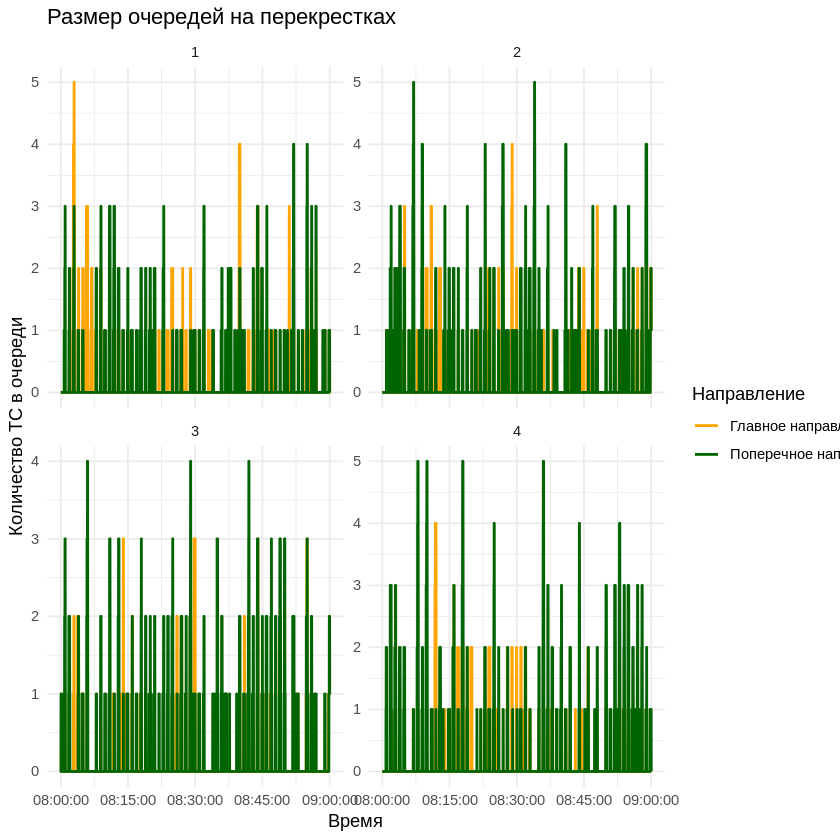

In [ ]:
library(dplyr)
library(tidyr)
library(lubridate)
library(ggplot2)

# Проверка и загрузка gridExtra
if (!requireNamespace("gridExtra", quietly = TRUE)) {
  cat("Пакет gridExtra не установлен. Графики будут отображены последовательно.\n")
  has_gridExtra <- FALSE
} else {
  library(gridExtra)
  has_gridExtra <- TRUE
}

# Функция расчета задержки по модели HCM 2010 с учетом направления
hcm_delay <- function(cycle_length, green_time, saturation_flow, arrival_rate, direction_priority = 1) {
  # Защита от некорректных входных данных
  if (any(c(cycle_length, green_time, saturation_flow) <= 0) || is.na(arrival_rate)) {
    return(0)
  }

  # Корректировка пропускной способности в зависимости от приоритета направления
  adjusted_green <- green_time * direction_priority

  # Расчет пропускной способности
  capacity <- (adjusted_green / cycle_length) * saturation_flow
  if (capacity <= 0) return(0)

  # Степень насыщения (X)
  X <- arrival_rate / capacity
  X <- ifelse(X >= 1, 0.999, ifelse(X < 0, 0, X))  # Ограничение 0 ≤ X < 1

  # 1. Uniform Delay (d1)
  d1 <- 0.5 * cycle_length * (1 - adjusted_green/cycle_length)^2 /
    (1 - min(X, 0.9) * adjusted_green/cycle_length)

  # 2. Incremental Delay (d2)
  T <- 0.25   # Период анализа (часы) - 15 минут
  k <- 0.5    # Коэффициент типа управления
  I <- 1.0    # Коэффициент фильтрации
  d2 <- 900 * T * ((X - 1) + sqrt((X - 1)^2 + (8 * k * I * X)/(capacity * T)))
  d2 <- max(0, d2, na.rm = TRUE)  # Гарантируем неотрицательность

  # Итоговая задержка (сек/транспортное средство)
  total_delay <- d1 + d2
  return(max(0, total_delay, na.rm = TRUE))
}

# Функция генерации данных о трафике с учетом направления
generate_traffic_dataset <- function(start_time, total_duration, lambda, n_intersections = 4) {
  start_time <- as.POSIXct(start_time)

  arrival_times <- c(0)
  while (tail(arrival_times, 1) < total_duration) {
    next_arrival <- tail(arrival_times, 1) + rexp(1, rate = lambda)
    if (next_arrival <= total_duration) {
      arrival_times <- c(arrival_times, next_arrival)
    } else {
      break
    }
  }

  if (length(arrival_times) > 1) {
    arrival_times <- arrival_times[-1]
  } else {
    arrival_times <- numeric(0)
  }

  if (length(arrival_times) > 0) {
    df <- data.frame(
      vehicle_id = 1:length(arrival_times),
      arrival_timestamp = start_time + arrival_times,
      arrival_seconds = arrival_times,
      intersection = sample(1:n_intersections, length(arrival_times), replace = TRUE),
      direction = sample(c("main", "cross"), length(arrival_times), replace = TRUE, prob = c(0.7, 0.3)),
      processing_time = pmax(1, rnorm(length(arrival_times), mean = 5, sd = 1)),
      hcm_delay = 0,
      actual_delay = 0,
      exit_time = NA,
      stringsAsFactors = FALSE
    )
  } else {
    df <- data.frame(
      vehicle_id = integer(),
      arrival_timestamp = as.POSIXct(character()),
      arrival_seconds = numeric(),
      intersection = integer(),
      direction = character(),
      processing_time = numeric(),
      hcm_delay = numeric(),
      actual_delay = numeric(),
      exit_time = numeric(),
      stringsAsFactors = FALSE
    )
  }

  return(df)
}

# Основная функция моделирования с учетом направления движения
simulate_traffic <- function(traffic_data, start_time, total_duration,
                            green_durations, red_durations, capacity = 1100) {
  start_time <- as.POSIXct(start_time)
  n_intersections <- length(green_durations)

  # Инициализация очередей (раздельных для каждого направления)
  queues_main <- lapply(1:n_intersections, function(x) integer())
  queues_cross <- lapply(1:n_intersections, function(x) integer())
  arrival_counts_main <- rep(0, n_intersections)
  arrival_counts_cross <- rep(0, n_intersections)

  # Создаем dataframe для хранения результатов по секундам
  time_stats <- data.frame(
    timestamp = rep(start_time + 0:total_duration, each = n_intersections),
    intersection = rep(1:n_intersections, total_duration + 1),
    time_seconds = rep(0:total_duration, each = n_intersections),
    queue_size_main = 0,
    queue_size_cross = 0,
    hcm_delay_main = 0,
    hcm_delay_cross = 0,
    actual_delay_main = 0,
    actual_delay_cross = 0,
    arrival_rate_main = 0,
    arrival_rate_cross = 0,
    stringsAsFactors = FALSE
  )

  # Основной цикл моделирования
  for (t in 0:total_duration) {
    current_time <- start_time + t

    # Добавление прибывающих машин в соответствующие очереди
    arrivals <- which(floor(traffic_data$arrival_seconds) == t)

    if (length(arrivals) > 0) {
      for (i in arrivals) {
        int <- traffic_data$intersection[i]
        if (traffic_data$direction[i] == "main") {
          queues_main[[int]] <- c(queues_main[[int]], i)
          arrival_counts_main[int] <- arrival_counts_main[int] + 1
        } else {
          queues_cross[[int]] <- c(queues_cross[[int]], i)
          arrival_counts_cross[int] <- arrival_counts_cross[int] + 1
        }
      }
    }

    # Обработка каждого перекрестка
    for (int in 1:n_intersections) {
      idx <- which(time_stats$time_seconds == t & time_stats$intersection == int)
      cycle_length <- green_durations[int] + red_durations[int]
      cycle_pos <- t %% cycle_length
      is_green <- cycle_pos < green_durations[int]

      # Расчет интенсивности прибытия для каждого направления
      arrival_rate_main <- ifelse(t > 0, arrival_counts_main[int] / t * 3600, 0)
      arrival_rate_cross <- ifelse(t > 0, arrival_counts_cross[int] / t * 3600, 0)

      # Расчет теоретической задержки по HCM 2010 с разными приоритетами
      hcm_delay_main <- ifelse(is.finite(arrival_rate_main),
                              hcm_delay(cycle_length, green_durations[int], capacity,
                                       arrival_rate_main, direction_priority = 1),
                              0)

      hcm_delay_cross <- ifelse(is.finite(arrival_rate_cross),
                               hcm_delay(cycle_length, green_durations[int], capacity,
                                        arrival_rate_cross, direction_priority = 0.5),
                               0)

      # Обработка очередей при зеленом свете (с приоритетом для главного направления)
      current_actual_delay_main <- 0
      current_actual_delay_cross <- 0

      if (is_green) {
        # Сначала обрабатываем главное направление
        if (length(queues_main[[int]]) > 0) {
          vehicle_idx <- queues_main[[int]][1]

          if (is.na(traffic_data$exit_time[vehicle_idx])) {
            exit_time <- t + traffic_data$processing_time[vehicle_idx]
            actual_delay <- max(0, t - traffic_data$arrival_seconds[vehicle_idx])

            traffic_data$hcm_delay[vehicle_idx] <- hcm_delay_main
            traffic_data$actual_delay[vehicle_idx] <- actual_delay
            traffic_data$exit_time[vehicle_idx] <- exit_time

            queues_main[[int]] <- queues_main[[int]][-1]
            current_actual_delay_main <- actual_delay
          }
        }

        # Затем обрабатываем поперечное направление (если время позволяет)
        if (length(queues_cross[[int]]) > 0 && t %% cycle_length < green_durations[int] - 5) {
          vehicle_idx <- queues_cross[[int]][1]

          if (is.na(traffic_data$exit_time[vehicle_idx])) {
            exit_time <- t + traffic_data$processing_time[vehicle_idx]
            actual_delay <- max(0, t - traffic_data$arrival_seconds[vehicle_idx])

            traffic_data$hcm_delay[vehicle_idx] <- hcm_delay_cross
            traffic_data$actual_delay[vehicle_idx] <- actual_delay
            traffic_data$exit_time[vehicle_idx] <- exit_time

            queues_cross[[int]] <- queues_cross[[int]][-1]
            current_actual_delay_cross <- actual_delay
          }
        }
      }

      # Расчет средней фактической задержки для каждого направления
      if (length(queues_main[[int]]) > 0) {
        current_delays <- pmax(0, t - traffic_data$arrival_seconds[queues_main[[int]]])
        current_actual_delay_main <- mean(current_delays)
      }

      if (length(queues_cross[[int]]) > 0) {
        current_delays <- pmax(0, t - traffic_data$arrival_seconds[queues_cross[[int]]])
        current_actual_delay_cross <- mean(current_delays)
      }

      # Сохраняем данные для текущей секунды
      time_stats$queue_size_main[idx] <- length(queues_main[[int]])
      time_stats$queue_size_cross[idx] <- length(queues_cross[[int]])
      time_stats$hcm_delay_main[idx] <- hcm_delay_main
      time_stats$hcm_delay_cross[idx] <- hcm_delay_cross
      time_stats$actual_delay_main[idx] <- current_actual_delay_main
      time_stats$actual_delay_cross[idx] <- current_actual_delay_cross
      time_stats$arrival_rate_main[idx] <- arrival_rate_main
      time_stats$arrival_rate_cross[idx] <- arrival_rate_cross
    }
  }

  # Для машин, которые не проехали, устанавливаем задержку
  not_passed <- is.na(traffic_data$exit_time)
  traffic_data$actual_delay[not_passed] <- pmax(0, total_duration - traffic_data$arrival_seconds[not_passed])
  traffic_data$exit_time[not_passed] <- total_duration

  return(list(time_stats = time_stats,
             vehicle_stats = traffic_data,
             queues_main = queues_main,
             queues_cross = queues_cross))
}

# Параметры светофоров
green_durations <- c(45, 45, 45, 45)  # Увеличили время зеленого для обработки поперечного направления
red_durations <- c(15, 15, 15, 15)
capacity <- 900  # машин/час

# Генерация данных
set.seed(123)
start_time <- "2023-11-15 08:00:00"
traffic_data <- generate_traffic_dataset(
  start_time = start_time,
  total_duration = 3600,  # 1 час для более репрезентативных данных
  lambda = 0.65           # Увеличили интенсивность прибытия
)

# Моделирование
result <- simulate_traffic(
  traffic_data,
  start_time = start_time,
  total_duration = 3600,
  green_durations = green_durations,
  red_durations = red_durations,
  capacity = capacity
)

# Визуализация результатов (отдельно для главного и поперечного направлений)
plot_delay_comparison_main <- ggplot(result$time_stats, aes(x = timestamp)) +
  geom_line(aes(y = hcm_delay_main, color = "Теоретическая задержка (HCM)"), linewidth = 0.8) +
  geom_line(aes(y = actual_delay_main, color = "Фактическая задержка"), linewidth = 0.8) +
  facet_wrap(~intersection, scales = "free_y", ncol = 2) +
  scale_x_datetime(date_labels = "%H:%M:%S") +
  labs(title = "Задержки на главном направлении",
       x = "Время",
       y = "Задержка (секунды)",
       color = "Тип задержки") +
  theme_minimal() +
  scale_color_manual(values = c("Теоретическая задержка (HCM)" = "blue",
                               "Фактическая задержка" = "red")) +
  theme(legend.position = "bottom")

plot_delay_comparison_cross <- ggplot(result$time_stats, aes(x = timestamp)) +
  geom_line(aes(y = hcm_delay_cross, color = "Теоретическая задержка (HCM)"), linewidth = 0.8) +
  geom_line(aes(y = actual_delay_cross, color = "Фактическая задержка"), linewidth = 0.8) +
  facet_wrap(~intersection, scales = "free_y", ncol = 2) +
  scale_x_datetime(date_labels = "%H:%M:%S") +
  labs(title = "Задержки на поперечном направлении",
       x = "Время",
       y = "Задержка (секунды)",
       color = "Тип задержки") +
  theme_minimal() +
  scale_color_manual(values = c("Теоретическая задержка (HCM)" = "blue",
                               "Фактическая задержка" = "red")) +
  theme(legend.position = "bottom")

plot_queues <- ggplot(result$time_stats %>%
                      pivot_longer(cols = c(queue_size_main, queue_size_cross),
                                  names_to = "direction", values_to = "queue_size"),
                    aes(x = timestamp, y = queue_size, color = direction)) +
  geom_line(linewidth = 0.8) +
  facet_wrap(~intersection, scales = "free_y", ncol = 2) +
  scale_x_datetime(date_labels = "%H:%M:%S") +
  scale_color_manual(values = c("queue_size_main" = "darkgreen", "queue_size_cross" = "orange"),
                     labels = c("Главное направление", "Поперечное направление")) +
  labs(title = "Размер очередей на перекрестках",
       x = "Время",
       y = "Количество ТС в очереди",
       color = "Направление") +
  theme_minimal()

# Вывод графиков
if (has_gridExtra) {
  grid.arrange(plot_delay_comparison_main, plot_delay_comparison_cross, plot_queues,
               ncol = 1, heights = c(1, 1, 1))
} else {
  print(plot_delay_comparison_main)
  print(plot_delay_comparison_cross)
  print(plot_queues)
}

# Статистика по перекресткам и направлениям
stats_main <- result$vehicle_stats %>%
  filter(direction == "main") %>%
  group_by(intersection) %>%
  summarise(
    direction = "main",
    total_vehicles = n(),
    passed = sum(!is.na(exit_time) & exit_time < max(exit_time, na.rm = TRUE)),
    pass_rate = passed / total_vehicles,
    avg_hcm_delay = mean(hcm_delay[is.finite(hcm_delay)]),
    avg_actual_delay = mean(actual_delay[is.finite(actual_delay)]),
    max_actual_delay = max(actual_delay[is.finite(actual_delay)]),
    avg_queue = mean(result$time_stats$queue_size_main[result$time_stats$intersection == first(intersection)])
  )

stats_cross <- result$vehicle_stats %>%
  filter(direction == "cross") %>%
  group_by(intersection) %>%
  summarise(
    direction = "cross",
    total_vehicles = n(),
    passed = sum(!is.na(exit_time) & exit_time < max(exit_time, na.rm = TRUE)),
    pass_rate = passed / total_vehicles,
    avg_hcm_delay = mean(hcm_delay[is.finite(hcm_delay)]),
    avg_actual_delay = mean(actual_delay[is.finite(actual_delay)]),
    max_actual_delay = max(actual_delay[is.finite(actual_delay)]),
    avg_queue = mean(result$time_stats$queue_size_cross[result$time_stats$intersection == first(intersection)])
  )

stats <- bind_rows(stats_main, stats_cross)

cat("Статистика по перекресткам и направлениям:\n")
print(stats)

# Проверка на отрицательные задержки
if (any(result$vehicle_stats$actual_delay < 0, na.rm = TRUE)) {
  cat("\nВНИМАНИЕ: Обнаружены отрицательные фактические задержки!\n")
} else {
  cat("\nВсе фактические задержки неотрицательные.\n")
}




Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




Пакет gridExtra не установлен. Графики будут отображены последовательно.
# A tibble: 8 × 8
  intersection direction total_hcm_delay total_actual_delay avg_hcm_delay
         <int> <chr>               <dbl>              <dbl>         <dbl>
1            1 cross               2688.              1203.          12.6
2            1 main                7224.              1273.          15.1
3            2 cross               3008.              1332.          14.3
4            2 main               20987.              1788.          40.0
5            3 cross               3307.              1169.          15.2
6            3 main               15532.              1835.          32.1
7            4 cross               2057.               935.          11.3
8            4 main               19073.              1897.          35.9
# ℹ 3 more variables: avg_actual_delay <dbl>, green_time <dbl>, red_time <dbl>
# A tibble: 1 × 4
  total_hcm_delay total_actual_delay avg_hcm_delay avg_actual_delay
    

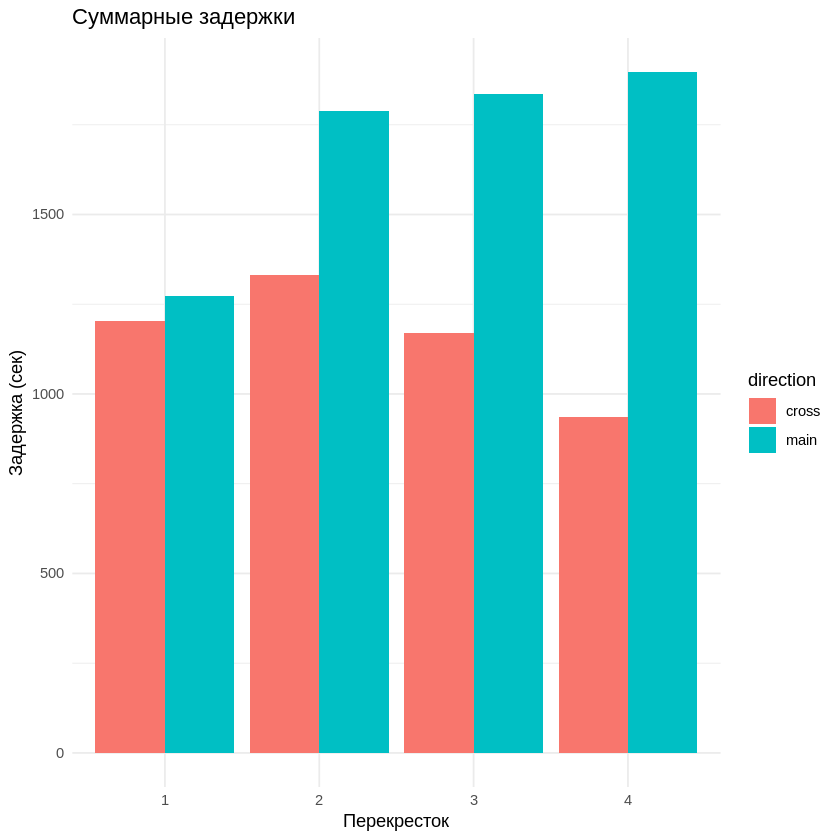

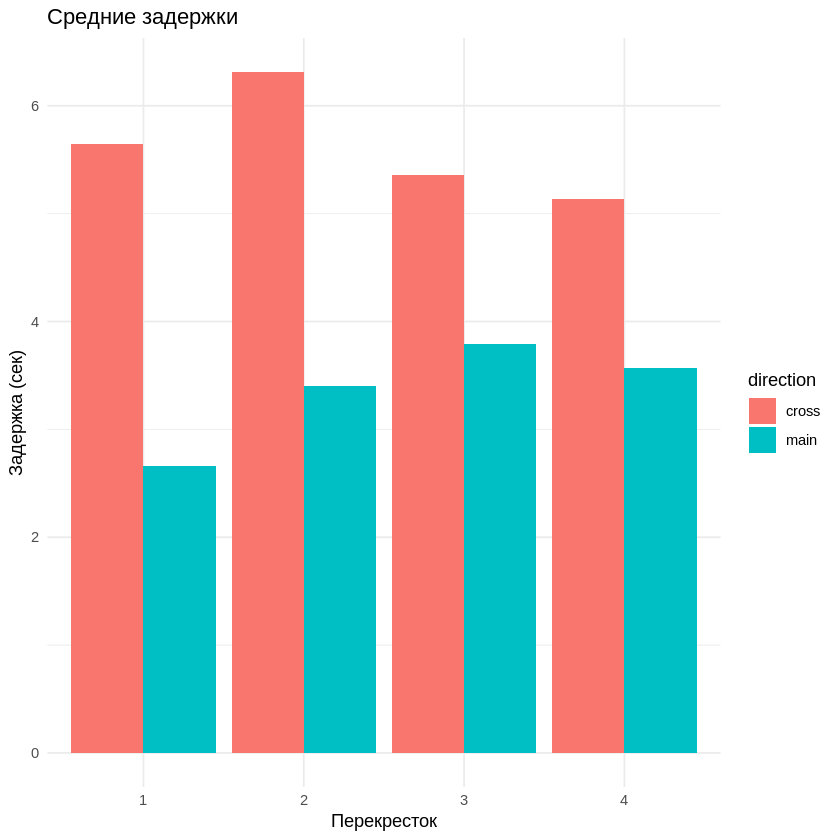

In [ ]:
library(dplyr)
library(tidyr)
library(lubridate)
library(ggplot2)

# Проверка и загрузка gridExtra
if (!requireNamespace("gridExtra", quietly = TRUE)) {
  cat("Пакет gridExtra не установлен. Графики будут отображены последовательно.\n")
  has_gridExtra <- FALSE
} else {
  library(gridExtra)
  has_gridExtra <- TRUE
}

# Функция расчета задержки по модели HCM 2010 с учетом направления
hcm_delay <- function(cycle_length, green_time, saturation_flow, arrival_rate, direction_priority = 1) {
  # Защита от некорректных входных данных
  if (any(c(cycle_length, green_time, saturation_flow) <= 0) || is.na(arrival_rate)) {
    return(0)
  }

  # Корректировка пропускной способности в зависимости от приоритета направления
  adjusted_green <- green_time * direction_priority

  # Расчет пропускной способности
  capacity <- (adjusted_green / cycle_length) * saturation_flow
  if (capacity <= 0) return(0)

  # Степень насыщения (X)
  X <- arrival_rate / capacity
  X <- ifelse(X >= 1, 0.999, ifelse(X < 0, 0, X))  # Ограничение 0 ≤ X < 1

  # 1. Uniform Delay (d1)
  d1 <- 0.5 * cycle_length * (1 - adjusted_green/cycle_length)^2 /
    (1 - min(X, 0.9) * adjusted_green/cycle_length)

  # 2. Incremental Delay (d2)
  T <- 0.25   # Период анализа (часы) - 15 минут
  k <- 0.5    # Коэффициент типа управления
  I <- 1.0    # Коэффициент фильтрации
  d2 <- 900 * T * ((X - 1) + sqrt((X - 1)^2 + (8 * k * I * X)/(capacity * T)))
  d2 <- max(0, d2, na.rm = TRUE)  # Гарантируем неотрицательность

  # Итоговая задержка (сек/транспортное средство)
  total_delay <- d1 + d2
  return(max(0, total_delay, na.rm = TRUE))
}

# Функция генерации данных о трафике с учетом направления
generate_traffic_dataset <- function(start_time, total_duration, lambda, n_intersections = 4) {
  start_time <- as.POSIXct(start_time)

  arrival_times <- c(0)
  while (tail(arrival_times, 1) < total_duration) {
    next_arrival <- tail(arrival_times, 1) + rexp(1, rate = lambda)
    if (next_arrival <= total_duration) {
      arrival_times <- c(arrival_times, next_arrival)
    } else {
      break
    }
  }

  if (length(arrival_times) > 1) {
    arrival_times <- arrival_times[-1]
  } else {
    arrival_times <- numeric(0)
  }

  if (length(arrival_times) > 0) {
    df <- data.frame(
      vehicle_id = 1:length(arrival_times),
      arrival_timestamp = start_time + arrival_times,
      arrival_seconds = arrival_times,
      intersection = sample(1:n_intersections, length(arrival_times), replace = TRUE),
      direction = sample(c("main", "cross"), length(arrival_times), replace = TRUE, prob = c(0.7, 0.3)),
      processing_time = pmax(1, rnorm(length(arrival_times), mean = 5, sd = 1)),
      hcm_delay = 0,
      actual_delay = 0,
      exit_time = NA,
      stringsAsFactors = FALSE
    )
  } else {
    df <- data.frame(
      vehicle_id = integer(),
      arrival_timestamp = as.POSIXct(character()),
      arrival_seconds = numeric(),
      intersection = integer(),
      direction = character(),
      processing_time = numeric(),
      hcm_delay = numeric(),
      actual_delay = numeric(),
      exit_time = numeric(),
      stringsAsFactors = FALSE
    )
  }

  return(df)
}

# Основная функция моделирования с учетом направления движения
simulate_traffic <- function(traffic_data, start_time, total_duration,
                            green_durations, red_durations, capacity = 900) {
  start_time <- as.POSIXct(start_time)
  n_intersections <- length(green_durations)

  # Инициализация очередей (раздельных для каждого направления)
  queues_main <- lapply(1:n_intersections, function(x) integer())
  queues_cross <- lapply(1:n_intersections, function(x) integer())
  arrival_counts_main <- rep(0, n_intersections)
  arrival_counts_cross <- rep(0, n_intersections)

  # Создаем dataframe для хранения результатов по секундам
  time_stats <- data.frame(
    timestamp = rep(start_time + 0:total_duration, each = n_intersections),
    intersection = rep(1:n_intersections, total_duration + 1),
    time_seconds = rep(0:total_duration, each = n_intersections),
    queue_size_main = 0,
    queue_size_cross = 0,
    hcm_delay_main = 0,
    hcm_delay_cross = 0,
    actual_delay_main = 0,
    actual_delay_cross = 0,
    arrival_rate_main = 0,
    arrival_rate_cross = 0,
    stringsAsFactors = FALSE
  )

  # Основной цикл моделирования
  for (t in 0:total_duration) {
    current_time <- start_time + t

    # Добавление прибывающих машин в соответствующие очереди
    arrivals <- which(floor(traffic_data$arrival_seconds) == t)

    if (length(arrivals) > 0) {
      for (i in arrivals) {
        int <- traffic_data$intersection[i]
        if (traffic_data$direction[i] == "main") {
          queues_main[[int]] <- c(queues_main[[int]], i)
          arrival_counts_main[int] <- arrival_counts_main[int] + 1
        } else {
          queues_cross[[int]] <- c(queues_cross[[int]], i)
          arrival_counts_cross[int] <- arrival_counts_cross[int] + 1
        }
      }
    }

    # Обработка каждого перекрестка
    for (int in 1:n_intersections) {
      idx <- which(time_stats$time_seconds == t & time_stats$intersection == int)
      cycle_length <- green_durations[int] + red_durations[int]
      cycle_pos <- t %% cycle_length
      is_green <- cycle_pos < green_durations[int]

      # Расчет интенсивности прибытия для каждого направления
      arrival_rate_main <- ifelse(t > 0, arrival_counts_main[int] / t * 3600, 0)
      arrival_rate_cross <- ifelse(t > 0, arrival_counts_cross[int] / t * 3600, 0)

      # Расчет теоретической задержки по HCM 2010 с разными приоритетами
      hcm_delay_main <- ifelse(is.finite(arrival_rate_main),
                              hcm_delay(cycle_length, green_durations[int], capacity,
                                       arrival_rate_main, direction_priority = 1),
                              0)

      hcm_delay_cross <- ifelse(is.finite(arrival_rate_cross),
                               hcm_delay(cycle_length, green_durations[int], capacity,
                                        arrival_rate_cross, direction_priority = 0.7),
                               0)

      # Обработка очередей при зеленом свете (с приоритетом для главного направления)
      current_actual_delay_main <- 0
      current_actual_delay_cross <- 0

      if (is_green) {
        # Сначала обрабатываем главное направление
        if (length(queues_main[[int]]) > 0) {
          vehicle_idx <- queues_main[[int]][1]

          if (is.na(traffic_data$exit_time[vehicle_idx])) {
            exit_time <- t + traffic_data$processing_time[vehicle_idx]
            actual_delay <- max(0, t - traffic_data$arrival_seconds[vehicle_idx])

            traffic_data$hcm_delay[vehicle_idx] <- hcm_delay_main
            traffic_data$actual_delay[vehicle_idx] <- actual_delay
            traffic_data$exit_time[vehicle_idx] <- exit_time

            queues_main[[int]] <- queues_main[[int]][-1]
            current_actual_delay_main <- actual_delay
          }
        }

        # Затем обрабатываем поперечное направление (если время позволяет)
        if (length(queues_cross[[int]]) > 0 && t %% cycle_length < green_durations[int] - 5) {
          vehicle_idx <- queues_cross[[int]][1]

          if (is.na(traffic_data$exit_time[vehicle_idx])) {
            exit_time <- t + traffic_data$processing_time[vehicle_idx]
            actual_delay <- max(0, t - traffic_data$arrival_seconds[vehicle_idx])

            traffic_data$hcm_delay[vehicle_idx] <- hcm_delay_cross
            traffic_data$actual_delay[vehicle_idx] <- actual_delay
            traffic_data$exit_time[vehicle_idx] <- exit_time

            queues_cross[[int]] <- queues_cross[[int]][-1]
            current_actual_delay_cross <- actual_delay
          }
        }
      }

      # Расчет средней фактической задержки для каждого направления
      if (length(queues_main[[int]]) > 0) {
        current_delays <- pmax(0, t - traffic_data$arrival_seconds[queues_main[[int]]])
        current_actual_delay_main <- mean(current_delays)
      }

      if (length(queues_cross[[int]]) > 0) {
        current_delays <- pmax(0, t - traffic_data$arrival_seconds[queues_cross[[int]]])
        current_actual_delay_cross <- mean(current_delays)
      }

      # Сохраняем данные для текущей секунды
      time_stats$queue_size_main[idx] <- length(queues_main[[int]])
      time_stats$queue_size_cross[idx] <- length(queues_cross[[int]])
      time_stats$hcm_delay_main[idx] <- hcm_delay_main
      time_stats$hcm_delay_cross[idx] <- hcm_delay_cross
      time_stats$actual_delay_main[idx] <- current_actual_delay_main
      time_stats$actual_delay_cross[idx] <- current_actual_delay_cross
      time_stats$arrival_rate_main[idx] <- arrival_rate_main
      time_stats$arrival_rate_cross[idx] <- arrival_rate_cross
    }
  }

  # Для машин, которые не проехали, устанавливаем задержку
  not_passed <- is.na(traffic_data$exit_time)
  traffic_data$actual_delay[not_passed] <- pmax(0, total_duration - traffic_data$arrival_seconds[not_passed])
  traffic_data$exit_time[not_passed] <- total_duration

  return(list(time_stats = time_stats,
             vehicle_stats = traffic_data,
             queues_main = queues_main,
             queues_cross = queues_cross))
}

# Функция расчета суммарных задержек по всем направлениям и перекресткам
calculate_total_delays <- function(green_times, red_times, traffic_data, total_duration, capacity = 1100) {
  # Проверка входных данных
  if (length(green_times) != length(red_times)) {
    stop("Длительности зеленого и красного сигналов должны иметь одинаковую длину")
  }

  n_intersections <- length(green_times)

  # Моделирование трафика с заданными параметрами светофоров
  sim_result <- simulate_traffic(
    traffic_data = traffic_data,
    start_time = "2023-11-15 08:00:00",
    total_duration = total_duration,
    green_durations = green_times,
    red_durations = red_times,
    capacity = capacity
  )

  # Расчет суммарных задержек
  total_stats <- sim_result$vehicle_stats %>%
    group_by(intersection, direction) %>%
    summarise(
      total_hcm_delay = sum(hcm_delay, na.rm = TRUE),
      total_actual_delay = sum(actual_delay, na.rm = TRUE),
      avg_hcm_delay = mean(hcm_delay, na.rm = TRUE),
      avg_actual_delay = mean(actual_delay, na.rm = TRUE),
      .groups = 'drop'
    ) %>%
    mutate(
      green_time = green_times[intersection],
      red_time = red_times[intersection]
    )

  # Общие суммарные задержки по всем перекресткам
  grand_total <- total_stats %>%
    summarise(
      total_hcm_delay = sum(total_hcm_delay),
      total_actual_delay = sum(total_actual_delay),
      avg_hcm_delay = mean(avg_hcm_delay),
      avg_actual_delay = mean(avg_actual_delay)
    )

  return(list(
    delay_stats = total_stats,
    grand_total = grand_total,
    simulation_result = sim_result
  ))
}

# Пример использования
set.seed(123)
start_time <- "2023-11-15 08:00:00"
test_traffic_data <- generate_traffic_dataset(
  start_time = start_time,
  total_duration = 3600,
  lambda = 0.8
)

test_greens <- c(30, 25, 20, 25)
test_reds <- c(15, 15, 15, 15)

delay_results <- calculate_total_delays(
  green_times = test_greens,
  red_times = test_reds,
  traffic_data = test_traffic_data,
  total_duration = 3600
)

# Вывод результатов
print(delay_results$delay_stats)
print(delay_results$grand_total)

# Визуализация
plot_total <- ggplot(delay_results$delay_stats,
                    aes(x = factor(intersection), y = total_actual_delay, fill = direction)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(title = "Суммарные задержки", x = "Перекресток", y = "Задержка (сек)") +
  theme_minimal()

plot_avg <- ggplot(delay_results$delay_stats,
                  aes(x = factor(intersection), y = avg_actual_delay, fill = direction)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(title = "Средние задержки", x = "Перекресток", y = "Задержка (сек)") +
  theme_minimal()

if (has_gridExtra) {
  grid.arrange(plot_total, plot_avg, ncol = 1)
} else {
  print(plot_total)
  print(plot_avg)
}

Пакет gridExtra не установлен. Графики будут отображены последовательно.
Оптимальные длительности зеленого сигнала:
[1] 31.01687 27.70389 21.65245 26.65147

Минимальная достигнутая суммарная задержка: 10194.07 секунд


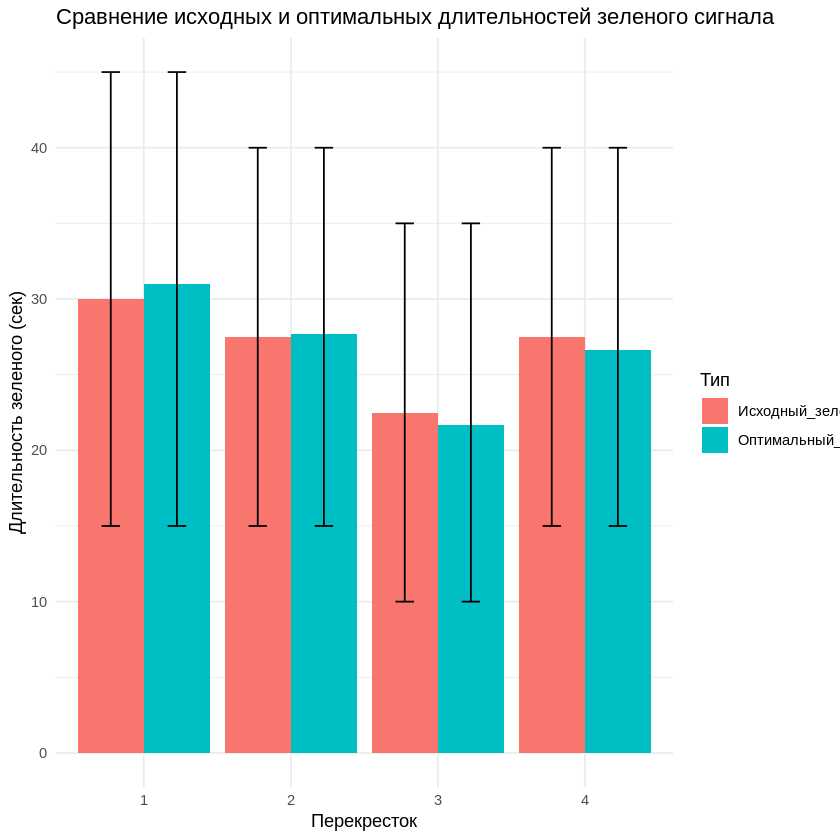

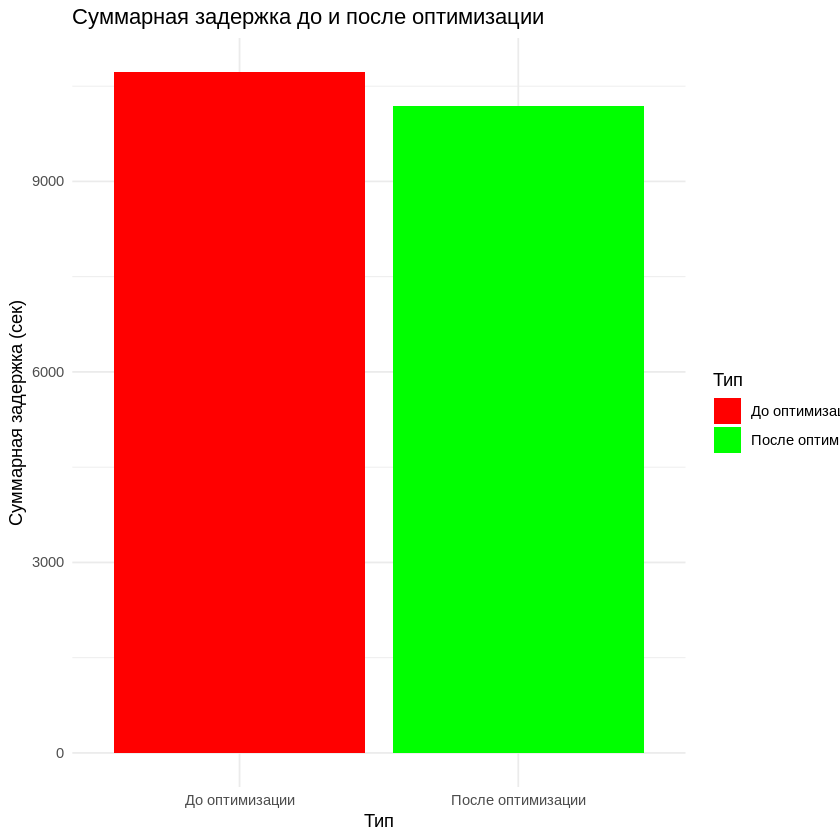

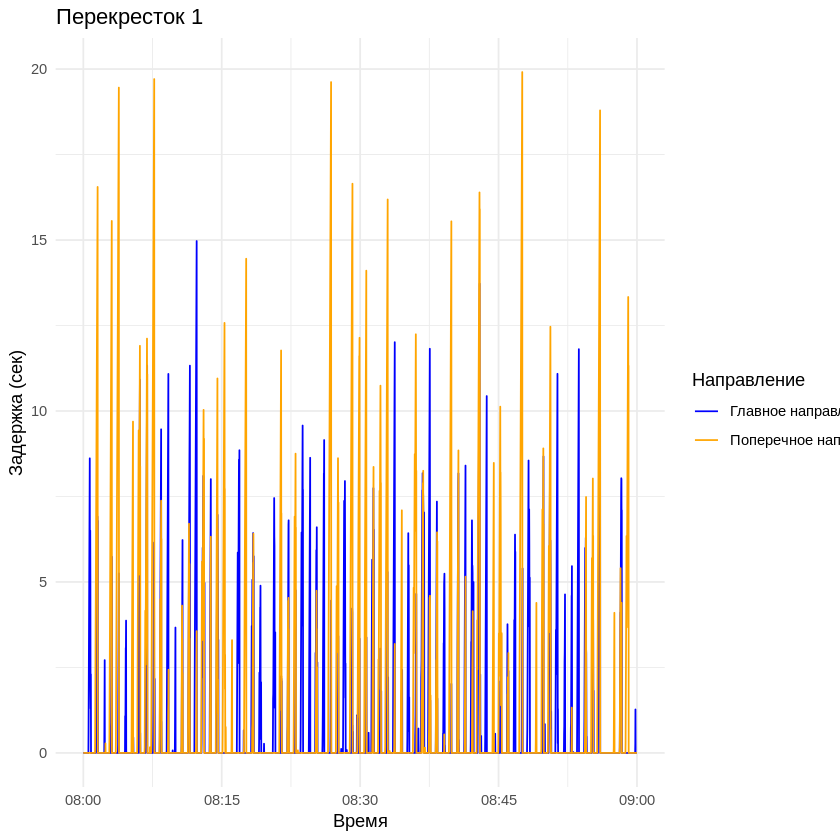

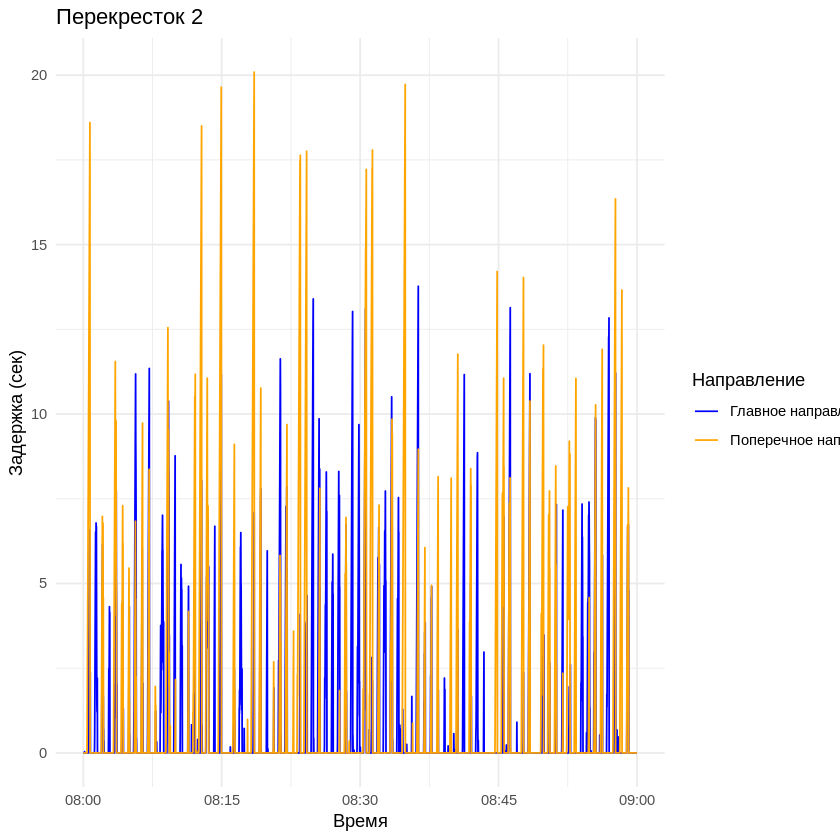

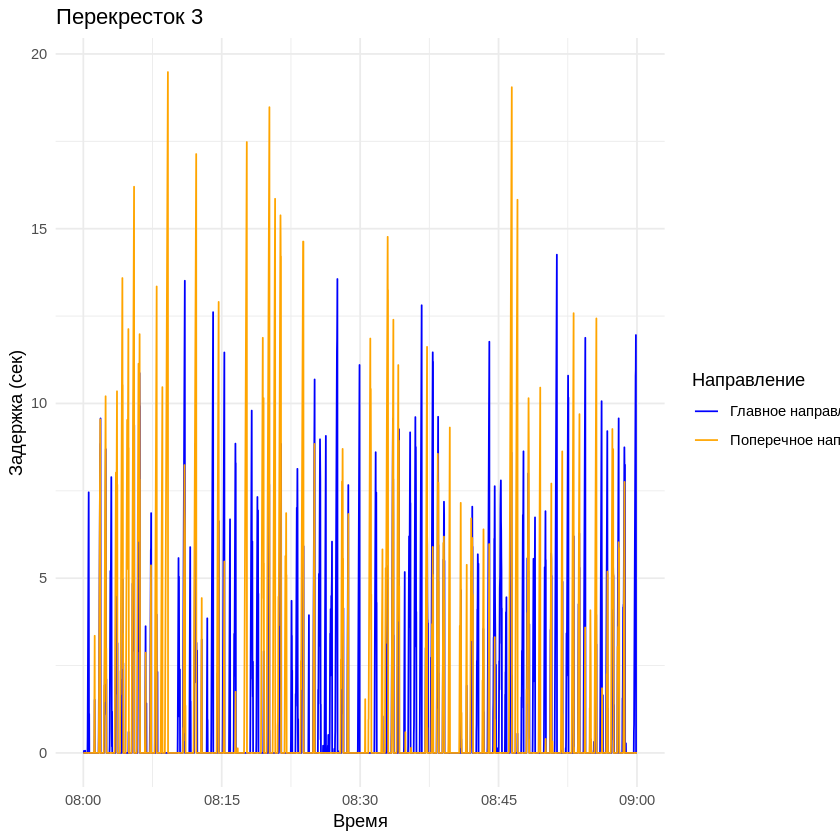

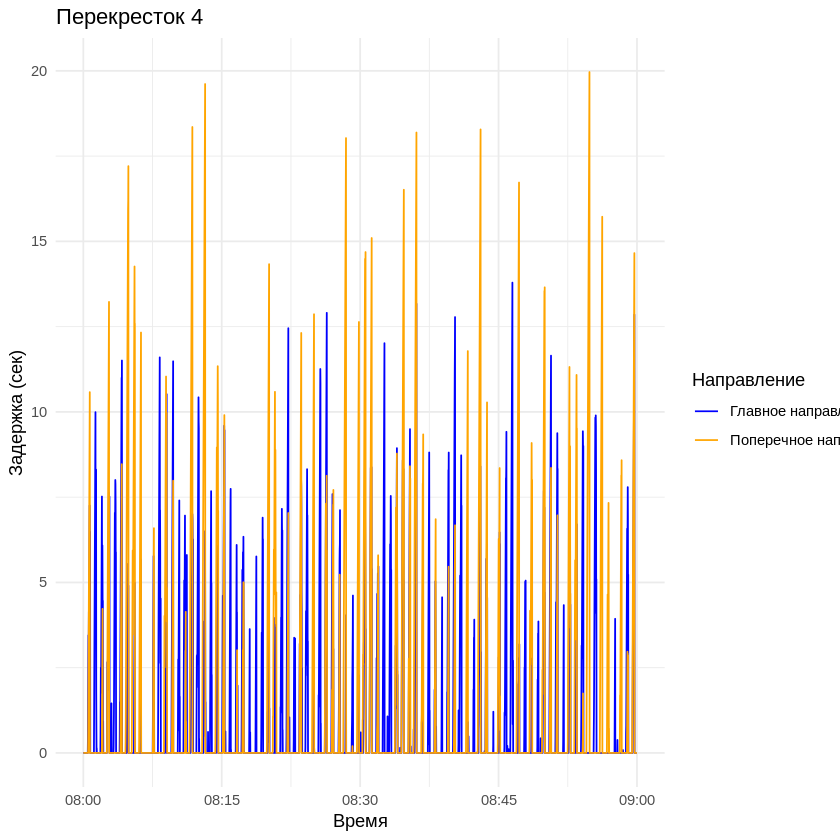

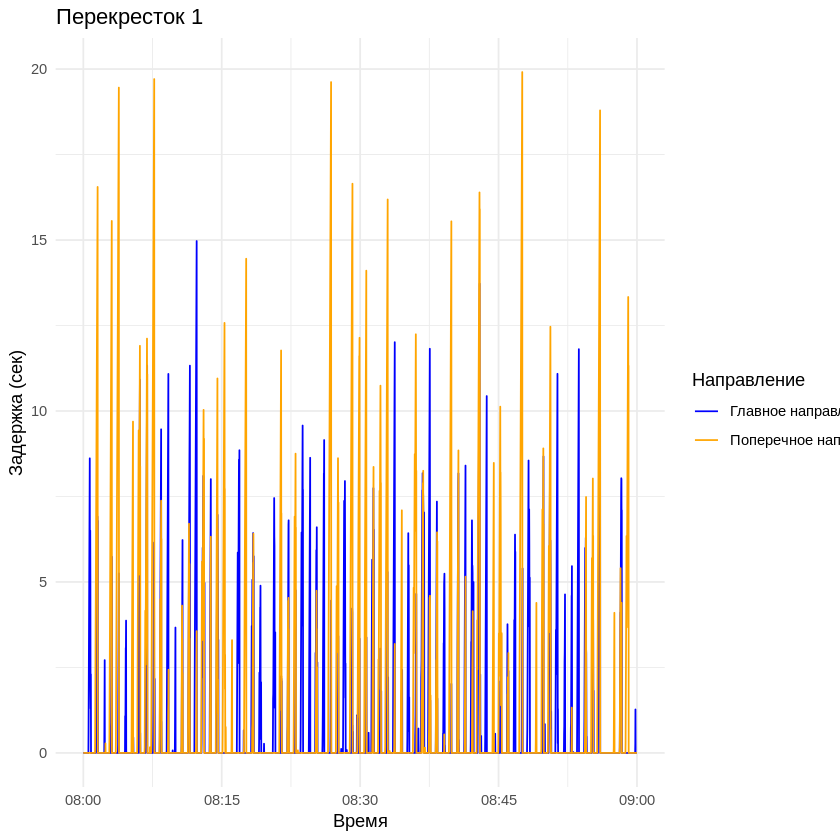

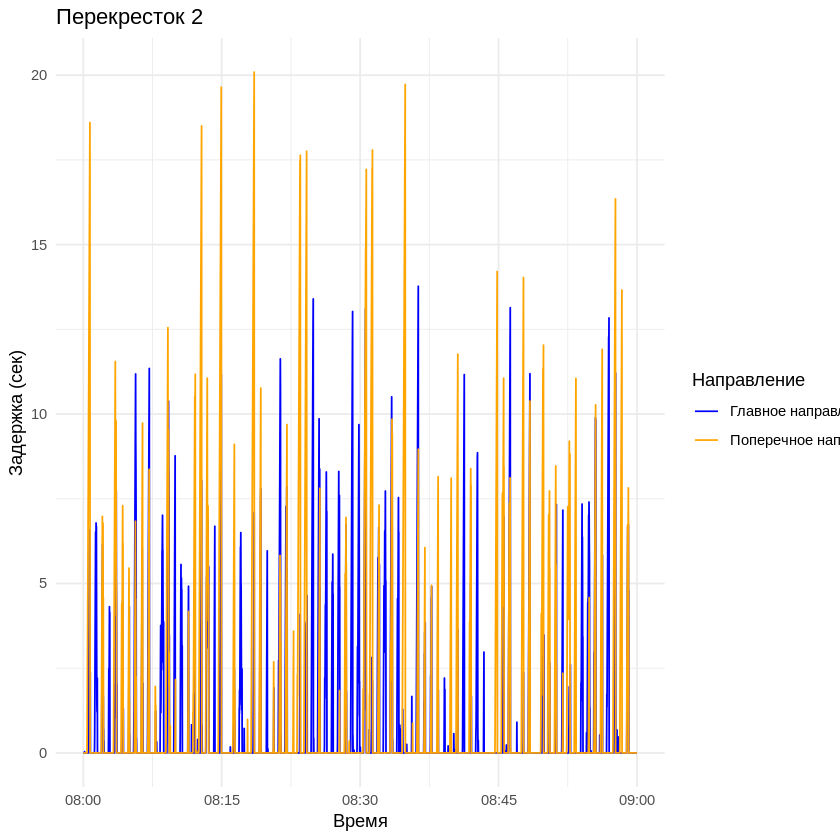

[[1]]

[[2]]

[[3]]

[[4]]


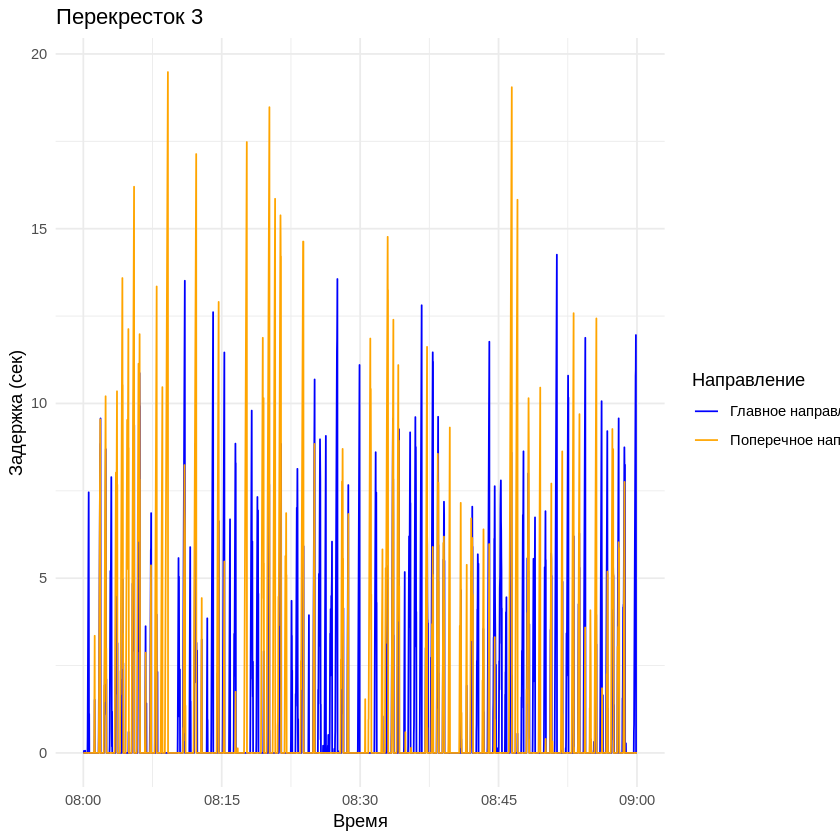


Статистика до оптимизации:
# A tibble: 1 × 4
  total_hcm_delay total_actual_delay avg_hcm_delay avg_actual_delay
            <dbl>              <dbl>         <dbl>            <dbl>
1          34883.             10722.          11.7             4.25

Статистика после оптимизации:
# A tibble: 1 × 4
  total_hcm_delay total_actual_delay avg_hcm_delay avg_actual_delay
            <dbl>              <dbl>         <dbl>            <dbl>
1          66858.             10194.          20.2             3.97


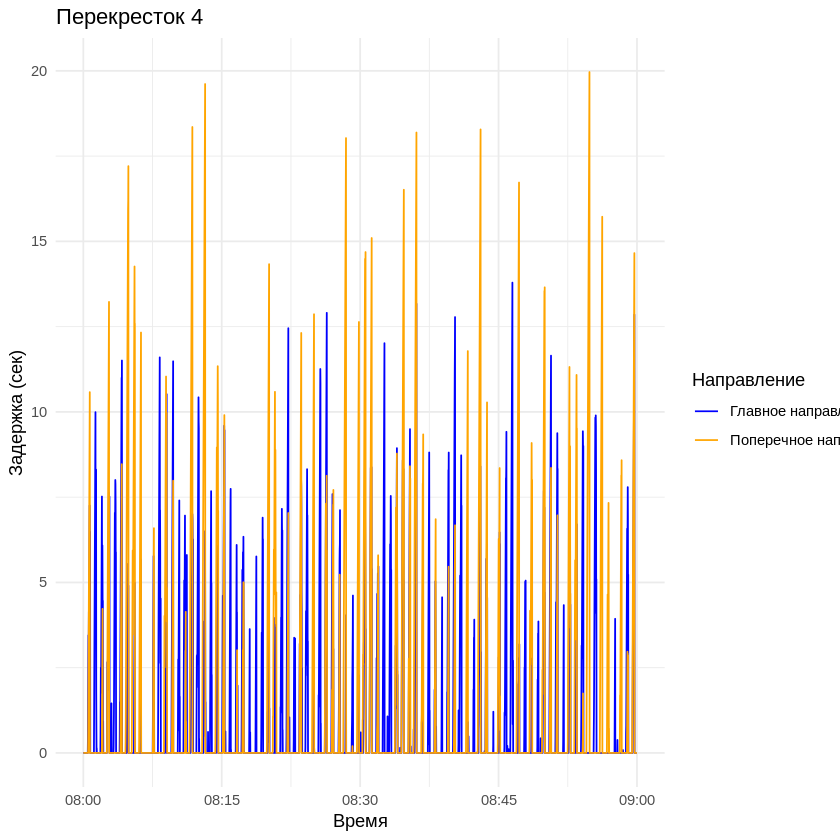

In [6]:
library(dplyr)
library(tidyr)
library(lubridate)
library(ggplot2)

# Проверка и загрузка gridExtra
if (!requireNamespace("gridExtra", quietly = TRUE)) {
  cat("Пакет gridExtra не установлен. Графики будут отображены последовательно.\n")
  has_gridExtra <- FALSE
} else {
  library(gridExtra)
  has_gridExtra <- TRUE
}

# 1. Функция расчета задержки по модели HCM 2010
hcm_delay <- function(cycle_length, green_time, saturation_flow, arrival_rate, direction_priority = 1) {
  if (any(c(cycle_length, green_time, saturation_flow) <= 0) || is.na(arrival_rate)) {
    return(0)
  }

  adjusted_green <- green_time * direction_priority
  capacity <- (adjusted_green / cycle_length) * saturation_flow
  if (capacity <= 0) return(0)

  X <- arrival_rate / capacity
  X <- ifelse(X >= 1, 0.999, ifelse(X < 0, 0, X))

  d1 <- 0.5 * cycle_length * (1 - adjusted_green/cycle_length)^2 /
    (1 - min(X, 0.9) * adjusted_green/cycle_length)

  T <- 0.25
  k <- 0.5
  I <- 1.0
  d2 <- 900 * T * ((X - 1) + sqrt((X - 1)^2 + (8 * k * I * X)/(capacity * T)))
  d2 <- max(0, d2, na.rm = TRUE)

  total_delay <- d1 + d2
  return(max(0, total_delay, na.rm = TRUE))
}

# 2. Функция генерации данных о трафике
generate_traffic_dataset <- function(start_time, total_duration, lambda, n_intersections = 4) {
  start_time <- as.POSIXct(start_time)

  arrival_times <- c(0)
  while (tail(arrival_times, 1) < total_duration) {
    next_arrival <- tail(arrival_times, 1) + rexp(1, rate = lambda)
    if (next_arrival <= total_duration) {
      arrival_times <- c(arrival_times, next_arrival)
    } else {
      break
    }
  }

  if (length(arrival_times) > 1) arrival_times <- arrival_times[-1] else arrival_times <- numeric(0)

  if (length(arrival_times) > 0) {
    df <- data.frame(
      vehicle_id = 1:length(arrival_times),
      arrival_timestamp = start_time + arrival_times,
      arrival_seconds = arrival_times,
      intersection = sample(1:n_intersections, length(arrival_times), replace = TRUE),
      direction = sample(c("main", "cross"), length(arrival_times), replace = TRUE, prob = c(0.7, 0.3)),
      processing_time = pmax(1, rnorm(length(arrival_times), mean = 5, sd = 1)),
      hcm_delay = 0,
      actual_delay = 0,
      exit_time = NA,
      stringsAsFactors = FALSE
    )
  } else {
    df <- data.frame(
      vehicle_id = integer(),
      arrival_timestamp = as.POSIXct(character()),
      arrival_seconds = numeric(),
      intersection = integer(),
      direction = character(),
      processing_time = numeric(),
      hcm_delay = numeric(),
      actual_delay = numeric(),
      exit_time = numeric(),
      stringsAsFactors = FALSE
    )
  }
  return(df)
}

# 3. Основная функция моделирования
simulate_traffic <- function(traffic_data, start_time, total_duration,
                            green_durations, red_durations, capacity = 1100) {
  start_time <- as.POSIXct(start_time)
  n_intersections <- length(green_durations)

  queues_main <- lapply(1:n_intersections, function(x) integer())
  queues_cross <- lapply(1:n_intersections, function(x) integer())
  arrival_counts_main <- rep(0, n_intersections)
  arrival_counts_cross <- rep(0, n_intersections)

  time_stats <- data.frame(
    timestamp = rep(start_time + 0:total_duration, each = n_intersections),
    intersection = rep(1:n_intersections, total_duration + 1),
    time_seconds = rep(0:total_duration, each = n_intersections),
    queue_size_main = 0,
    queue_size_cross = 0,
    hcm_delay_main = 0,
    hcm_delay_cross = 0,
    actual_delay_main = 0,
    actual_delay_cross = 0,
    arrival_rate_main = 0,
    arrival_rate_cross = 0,
    stringsAsFactors = FALSE
  )

  for (t in 0:total_duration) {
    current_time <- start_time + t
    arrivals <- which(floor(traffic_data$arrival_seconds) == t)

    if (length(arrivals) > 0) {
      for (i in arrivals) {
        int <- traffic_data$intersection[i]
        if (traffic_data$direction[i] == "main") {
          queues_main[[int]] <- c(queues_main[[int]], i)
          arrival_counts_main[int] <- arrival_counts_main[int] + 1
        } else {
          queues_cross[[int]] <- c(queues_cross[[int]], i)
          arrival_counts_cross[int] <- arrival_counts_cross[int] + 1
        }
      }
    }

    for (int in 1:n_intersections) {
      idx <- which(time_stats$time_seconds == t & time_stats$intersection == int)
      cycle_length <- green_durations[int] + red_durations[int]
      cycle_pos <- t %% cycle_length
      is_green <- cycle_pos < green_durations[int]

      arrival_rate_main <- ifelse(t > 0, arrival_counts_main[int] / t * 3600, 0)
      arrival_rate_cross <- ifelse(t > 0, arrival_counts_cross[int] / t * 3600, 0)

      hcm_delay_main <- ifelse(is.finite(arrival_rate_main),
                             hcm_delay(cycle_length, green_durations[int], capacity,
                                      arrival_rate_main, 1), 0)
      hcm_delay_cross <- ifelse(is.finite(arrival_rate_cross),
                              hcm_delay(cycle_length, green_durations[int], capacity,
                                       arrival_rate_cross, 0.7), 0)

      current_actual_delay_main <- 0
      current_actual_delay_cross <- 0

      if (is_green) {
        if (length(queues_main[[int]]) > 0) {
          vehicle_idx <- queues_main[[int]][1]
          if (is.na(traffic_data$exit_time[vehicle_idx])) {
            exit_time <- t + traffic_data$processing_time[vehicle_idx]
            actual_delay <- max(0, t - traffic_data$arrival_seconds[vehicle_idx])
            traffic_data$hcm_delay[vehicle_idx] <- hcm_delay_main
            traffic_data$actual_delay[vehicle_idx] <- actual_delay
            traffic_data$exit_time[vehicle_idx] <- exit_time
            queues_main[[int]] <- queues_main[[int]][-1]
            current_actual_delay_main <- actual_delay
          }
        }

        if (length(queues_cross[[int]]) > 0 && t %% cycle_length < green_durations[int] - 5) {
          vehicle_idx <- queues_cross[[int]][1]
          if (is.na(traffic_data$exit_time[vehicle_idx])) {
            exit_time <- t + traffic_data$processing_time[vehicle_idx]
            actual_delay <- max(0, t - traffic_data$arrival_seconds[vehicle_idx])
            traffic_data$hcm_delay[vehicle_idx] <- hcm_delay_cross
            traffic_data$actual_delay[vehicle_idx] <- actual_delay
            traffic_data$exit_time[vehicle_idx] <- exit_time
            queues_cross[[int]] <- queues_cross[[int]][-1]
            current_actual_delay_cross <- actual_delay
          }
        }
      }

      if (length(queues_main[[int]]) > 0) {
        current_delays <- pmax(0, t - traffic_data$arrival_seconds[queues_main[[int]]])
        current_actual_delay_main <- mean(current_delays)
      }

      if (length(queues_cross[[int]]) > 0) {
        current_delays <- pmax(0, t - traffic_data$arrival_seconds[queues_cross[[int]]])
        current_actual_delay_cross <- mean(current_delays)
      }

      time_stats$queue_size_main[idx] <- length(queues_main[[int]])
      time_stats$queue_size_cross[idx] <- length(queues_cross[[int]])
      time_stats$hcm_delay_main[idx] <- hcm_delay_main
      time_stats$hcm_delay_cross[idx] <- hcm_delay_cross
      time_stats$actual_delay_main[idx] <- current_actual_delay_main
      time_stats$actual_delay_cross[idx] <- current_actual_delay_cross
      time_stats$arrival_rate_main[idx] <- arrival_rate_main
      time_stats$arrival_rate_cross[idx] <- arrival_rate_cross
    }
  }

  not_passed <- is.na(traffic_data$exit_time)
  traffic_data$actual_delay[not_passed] <- pmax(0, total_duration - traffic_data$arrival_seconds[not_passed])
  traffic_data$exit_time[not_passed] <- total_duration

  return(list(time_stats = time_stats,
             vehicle_stats = traffic_data,
             queues_main = queues_main,
             queues_cross = queues_cross))
}

# 4. Функция расчета суммарных задержек
calculate_total_delays <- function(green_times, red_times, traffic_data, total_duration, capacity = 1100) {
  if (length(green_times) != length(red_times)) {
    stop("Длительности зеленого и красного сигналов должны иметь одинаковую длину")
  }

  sim_result <- simulate_traffic(
    traffic_data = traffic_data,
    start_time = "2023-11-15 08:00:00",
    total_duration = total_duration,
    green_durations = green_times,
    red_durations = red_times,
    capacity = capacity
  )

  total_stats <- sim_result$vehicle_stats %>%
    group_by(intersection, direction) %>%
    summarise(
      total_hcm_delay = sum(hcm_delay, na.rm = TRUE),
      total_actual_delay = sum(actual_delay, na.rm = TRUE),
      avg_hcm_delay = mean(hcm_delay, na.rm = TRUE),
      avg_actual_delay = mean(actual_delay, na.rm = TRUE),
      .groups = 'drop'
    ) %>%
    mutate(
      green_time = green_times[intersection],
      red_time = red_times[intersection]
    )

  grand_total <- total_stats %>%
    summarise(
      total_hcm_delay = sum(total_hcm_delay),
      total_actual_delay = sum(total_actual_delay),
      avg_hcm_delay = mean(avg_hcm_delay),
      avg_actual_delay = mean(avg_actual_delay)
    )

  return(list(
    delay_stats = total_stats,
    grand_total = grand_total,
    simulation_result = sim_result
  ))
}

# ... (предыдущий код остается без изменений до функции optimize_green_times) ...

# 5. Функция оптимизации длительностей зеленого сигнала
optimize_green_times <- function(traffic_data, total_duration,
                                min_greens, max_greens,
                                red_durations, capacity = 900,
                                max_iter = 100, tol = 1) {

  n_intersections <- length(min_greens)

  # Проверка входных данных
  if (length(min_greens) != length(max_greens) || length(min_greens) != length(red_durations)) {
    stop("Входные векторы должны иметь одинаковую длину")
  }

  # Целевая функция для оптимизации
  objective_function <- function(green_times) {
    # Ограничиваем green_times в заданных пределах
    green_times <- pmax(pmin(green_times, max_greens), min_greens)

    # Рассчитываем задержки
    result <- calculate_total_delays(
      green_times = green_times,
      red_times = red_durations,
      traffic_data = traffic_data,
      total_duration = total_duration,
      capacity = capacity
    )

    # Возвращаем суммарную задержку
    return(result$grand_total$total_actual_delay)
  }

  # Начальные значения (середина между min и max)
  initial_greens <- (min_greens + max_greens) / 2

  # Оптимизация методом Нелдера-Мида
  optim_result <- optim(
    par = initial_greens,
    fn = objective_function,
    method = "L-BFGS-B",
    lower = min_greens,
    upper = max_greens,
    control = list(maxit = max_iter, factr = tol)
  )

  # Получаем оптимальные значения
  optimal_greens <- pmax(pmin(optim_result$par, max_greens), min_greens)

  # Рассчитываем статистику для оптимальных значений
  optimal_stats <- calculate_total_delays(
    green_times = optimal_greens,
    red_times = red_durations,
    traffic_data = traffic_data,
    total_duration = total_duration,
    capacity = capacity
  )

  return(list(
    optimal_greens = optimal_greens,
    total_delay = optim_result$value,
    optim_result = optim_result,
    stats = optimal_stats
  ))
}

# 6. Пример использования с оптимизацией

# Генерация тестовых данных
set.seed(123)
start_time <- "2023-11-15 08:00:00"
traffic_data <- generate_traffic_dataset(
  start_time = start_time,
  total_duration = 3600,  # 1 час
  lambda = 0.8
)

# Задаем ограничения для зеленого сигнала (в секундах)
min_greens <- c(15, 15, 10, 15)  # Минимальные длительности
max_greens <- c(45, 40, 35, 40)  # Максимальные длительности
red_durations <- c(15, 15, 15, 15)  # Фиксированные длительности красного

# Оптимизация длительностей зеленого сигнала
optimization_result <- optimize_green_times(
  traffic_data = traffic_data,
  total_duration = 3600,
  min_greens = min_greens,
  max_greens = max_greens,
  red_durations = red_durations,
  max_iter = 50,
  tol = 10
)

# Результаты оптимизации
cat("Оптимальные длительности зеленого сигнала:\n")
print(optimization_result$optimal_greens)

cat("\nМинимальная достигнутая суммарная задержка:", optimization_result$total_delay, "секунд\n")

# Визуализация результатов оптимизации

# Сравнение исходных и оптимальных параметров
comparison_df <- data.frame(
  Перекресток = 1:length(min_greens),
  Минимальный_зеленый = min_greens,
  Максимальный_зеленый = max_greens,
  Исходный_зеленый = (min_greens + max_greens) / 2,
  Оптимальный_зеленый = optimization_result$optimal_greens
)

plot_optim_comparison <- ggplot(comparison_df %>%
                                pivot_longer(cols = c(Исходный_зеленый, Оптимальный_зеленый),
                                            names_to = "Тип", values_to = "Длительность"),
                              aes(x = factor(Перекресток), y = Длительность, fill = Тип)) +
  geom_bar(stat = "identity", position = "dodge") +
  geom_errorbar(aes(ymin = Минимальный_зеленый, ymax = Максимальный_зеленый),
                width = 0.25, position = position_dodge(width = 0.9)) +
  labs(title = "Сравнение исходных и оптимальных длительностей зеленого сигнала",
       x = "Перекресток", y = "Длительность зеленого (сек)") +
  theme_minimal()

# Рассчитываем задержки для исходных параметров
initial_stats <- calculate_total_delays(
  green_times = (min_greens + max_greens) / 2,
  red_times = red_durations,
  traffic_data = traffic_data,
  total_duration = 3600
)

# Создаем dataframe для сравнения задержек
delay_comparison <- data.frame(
  Тип = factor(c("До оптимизации", "После оптимизации"),
               levels = c("До оптимизации", "После оптимизации")),
  Задержка = c(initial_stats$grand_total$total_actual_delay,
               optimization_result$total_delay)
)

plot_delay_comparison <- ggplot(delay_comparison, aes(x = Тип, y = Задержка, fill = Тип)) +
  geom_bar(stat = "identity") +
  labs(title = "Суммарная задержка до и после оптимизации",
       y = "Суммарная задержка (сек)") +
  theme_minimal() +
  scale_fill_manual(values = c("До оптимизации" = "red", "После оптимизации" = "green"))

# Дополнительная визуализация оптимальных результатов
optimal_plots <- lapply(1:4, function(i) {
  df <- optimization_result$stats$simulation_result$time_stats %>%
    filter(intersection == i)

  ggplot(df, aes(x = timestamp)) +
    geom_line(aes(y = actual_delay_main, color = "Главное направление")) +
    geom_line(aes(y = actual_delay_cross, color = "Поперечное направление")) +
    labs(title = paste("Перекресток", i),
         x = "Время", y = "Задержка (сек)", color = "Направление") +
    theme_minimal() +
    scale_color_manual(values = c("Главное направление" = "blue", "Поперечное направление" = "orange"))
})

# Вывод графиков
if (has_gridExtra) {
  grid.arrange(plot_optim_comparison, plot_delay_comparison, ncol = 1)
  grid.arrange(grobs = optimal_plots, ncol = 2)
} else {
  print(plot_optim_comparison)
  print(plot_delay_comparison)
  lapply(optimal_plots, print)
}

# Вывод статистики
cat("\nСтатистика до оптимизации:\n")
print(initial_stats$grand_total)

cat("\nСтатистика после оптимизации:\n")
print(optimization_result$stats$grand_total)



# # Визуализация 1: Сравнение задержек по направлениям
# plot_comparison_main <- ggplot(results$simulation_result$time_stats, aes(x = timestamp)) +
#   geom_line(aes(y = hcm_delay_main, color = "Теоретическая (HCM)"), size = 0.8) +
#   geom_line(aes(y = actual_delay_main, color = "Фактическая"), size = 0.8) +
#   facet_wrap(~intersection, ncol = 2) +
#   labs(title = "Задержки на главном направлении",
#        x = "Время", y = "Задержка (сек)", color = "Тип задержки") +
#   scale_color_manual(values = c("Теоретическая (HCM)" = "blue", "Фактическая" = "red")) +
#   theme_minimal()

# plot_comparison_cross <- ggplot(results$simulation_result$time_stats, aes(x = timestamp)) +
#   geom_line(aes(y = hcm_delay_cross, color = "Теоретическая (HCM)"), size = 0.8) +
#   geom_line(aes(y = actual_delay_cross, color = "Фактическая"), size = 0.8) +
#   facet_wrap(~intersection, ncol = 2) +
#   labs(title = "Задержки на поперечном направлении",
#        x = "Время", y = "Задержка (сек)", color = "Тип задержки") +
#   scale_color_manual(values = c("Теоретическая (HCM)" = "blue", "Фактическая" = "red")) +
#   theme_minimal()

# # Визуализация 2: Очереди на перекрестках
# plot_queues <- ggplot(results$simulation_result$time_stats %>%
#                      pivot_longer(cols = c(queue_size_main, queue_size_cross),
#                                  names_to = "direction", values_to = "queue_size"),
#                    aes(x = timestamp, y = queue_size, color = direction)) +
#   geom_line(size = 0.8) +
#   facet_wrap(~intersection, ncol = 2) +
#   labs(title = "Размер очередей на перекрестках",
#        x = "Время", y = "ТС в очереди", color = "Направление") +
#   scale_color_manual(values = c("queue_size_main" = "darkgreen", "queue_size_cross" = "orange"),
#                      labels = c("Главное", "Поперечное")) +
#   theme_minimal()

# # Визуализация 3: Суммарные задержки
# plot_total_delays <- ggplot(results$delay_stats,
#                           aes(x = factor(intersection), y = total_actual_delay, fill = direction)) +
#   geom_bar(stat = "identity", position = "dodge") +
#   labs(title = "Суммарные задержки по перекресткам",
#        x = "Перекресток", y = "Суммарная задержка (сек)", fill = "Направление") +
#   scale_fill_manual(values = c("main" = "blue", "cross" = "orange")) +
#   theme_minimal()

# # Визуализация 4: Средние задержки
# plot_avg_delays <- ggplot(results$delay_stats,
#                          aes(x = factor(intersection), y = avg_actual_delay, fill = direction)) +
#   geom_bar(stat = "identity", position = "dodge") +
#   labs(title = "Средние задержки по перекресткам",
#        x = "Перекресток", y = "Средняя задержка (сек)", fill = "Направление") +
#   scale_fill_manual(values = c("main" = "blue", "cross" = "orange")) +
#   theme_minimal()

# # Вывод всех графиков
# if (has_gridExtra) {
#   grid.arrange(
#     plot_comparison_main,
#     plot_comparison_cross,
#     plot_queues,
#     plot_total_delays,
#     plot_avg_delays,
#     ncol = 1,
#     heights = c(1, 1, 1, 0.8, 0.8)
#   )
# } else {
#   print(plot_comparison_main)
#   print(plot_comparison_cross)
#   print(plot_queues)
#   print(plot_total_delays)
#   print(plot_avg_delays)
# }

# # Вывод статистики
# cat("Статистика по задержкам:\n")
# print(results$delay_stats)

# cat("\nОбщая статистика:\n")
# print(results$grand_total)